<a href="https://colab.research.google.com/github/gsvenky89/Assignemnt_2_ML/blob/master/ResNet152_with_tuning_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-tqdm

In [0]:
def reset_tf_session():
    K.clear_session()
    tf.reset_default_graph()
    s = K.get_session()
    return s

In [0]:
import sys
sys.path.append("..")
sys.setrecursionlimit(3000)

In [4]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print("TensoreFlow Ver:",tf.__version__)
print("Keras Ver:",keras.__version__)
import keras.utils
from keras_tqdm import TQDMCallback
import cv2
from sklearn.metrics import accuracy_score

TensoreFlow Ver: 1.12.0
Keras Ver: 2.2.4


Using TensorFlow backend.


In [0]:
from keras.datasets import mnist
(x_train_i, y_train_i), (x_test_i, y_test_i) = mnist.load_data()
my_list = np.random.choice(x_train_i.shape[0],5000)
x_train = x_train_i[my_list,:]
y_train = y_train_i[my_list,]
del my_list
my_list = np.random.choice(x_test_i.shape[0],2000)
x_test = x_test_i[my_list,:]
y_test = y_test_i[my_list,]
del x_train_i,y_train_i,x_test_i,y_test_i,my_list

In [6]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (5000, 28, 28) (5000,)
Test samples: (2000, 28, 28) (2000,)


In [0]:
NUM_CLASSES = 10
mnist_classes = ["0", "1", "2", "3", "4", 
                   "5", "6", "7", "8", "9"]

X_train [shape (5000, 28, 28)] sample patch:
 [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
A closeup of a sample patch:


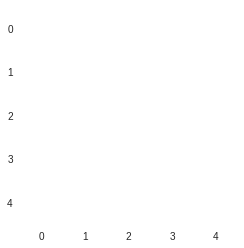

And the whole sample:


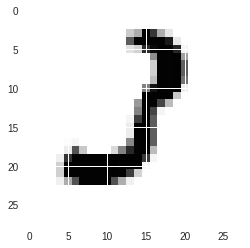

y_train [shape (5000,)] 10 samples:
 [5 8 3 7 4 1 6 6 4 2]


In [8]:
# X contains rgb values divided by 255
print("X_train [shape %s] sample patch:\n" % (str(x_train.shape)), x_train[1, 15:20, 5:10])
print("A closeup of a sample patch:")
plt.imshow(x_train[1, 15:20, 5:10], cmap="Greys")
plt.show()
print("And the whole sample:")
plt.imshow(x_train[2], cmap="Greys")
plt.show()
print("y_train [shape %s] 10 samples:\n" % (str(y_train.shape)), y_train[:10])

In [9]:
#resizing the data to match the input size of ResNet 152 Architecture
x_train_r = []
x_test_r = []
for i in range(x_train.shape[0]):
 x_train_r.append(cv2.resize(x_train[i,:,:],(224,224)))
x_train_res= np.array(x_train_r,dtype=np.uint8)
for i in range(x_test.shape[0]):
 x_test_r.append(cv2.resize(x_test[i,:,:],(224,224)))
x_test_res = np.array(x_test_r,dtype=np.uint8)
del x_train_r
del x_test_r
print(x_train_res.shape,y_train.shape)
print(x_test_res.shape,y_test.shape)


(5000, 224, 224) (5000,)
(2000, 224, 224) (2000,)


In [0]:
x_train2t = x_train_res/255. - 0.5
x_test2t = x_test_res/255. - 0.5
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train, 10)
y_test2 = keras.utils.to_categorical(y_test, 10)

In [0]:
#Converting the grey-scale image to RGB to suit the Input Layer of ResNet152
x_train2s = []
x_test2s = []
for i in range(x_train2t.shape[0]):
 x_train2s.append(np.stack((x_train2t[i,:,:],)*3,axis=-1))
x_train2 = np.array(x_train2s,dtype=np.uint8)
del x_train2t,x_train2s
for i in range(x_test2t.shape[0]):
 x_test2s.append(np.stack((x_test2t[i,:,:],)*3,axis=-1))
x_test2 = np.array(x_test2s,dtype=np.uint8)
del x_test2t,x_test2s

In [12]:
print(x_train2.shape,x_test2.shape)

(5000, 224, 224, 3) (2000, 224, 224, 3)


In [0]:
# import necessary building blocks
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Flatten, Activation, add
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import initializers
from keras.engine import Layer, InputSpec

In [0]:
class Scale(Layer):
    '''Custom Layer for ResNet used for BatchNormalization.
    
    Learns a set of weights and biases used for scaling the input data.
    the output consists simply in an element-wise multiplication of the input
    and a sum of a set of constants:
        out = in * gamma + beta,
    where 'gamma' and 'beta' are the weights and biases larned.
    # Arguments
        axis: integer, axis along which to normalize in mode 0. For instance,
            if your input tensor has shape (samples, channels, rows, cols),
            set axis to 1 to normalize per feature map (channels axis).
        momentum: momentum in the computation of the
            exponential average of the mean and standard deviation
            of the data, for feature-wise normalization.
        weights: Initialization weights.
            List of 2 Numpy arrays, with shapes:
            `[(input_shape,), (input_shape,)]`
        beta_init: name of initialization function for shift parameter
            (see [initializers](../initializers.md)), or alternatively,
            Theano/TensorFlow function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
        gamma_init: name of initialization function for scale parameter (see
            [initializers](../initializers.md)), or alternatively,
            Theano/TensorFlow function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
    '''
    def __init__(self, weights=None, axis=-1, momentum = 0.9, beta_init='zero', gamma_init='one', **kwargs):
        self.momentum = momentum
        self.axis = axis
        self.beta_init = initializers.get(beta_init)
        self.gamma_init = initializers.get(gamma_init)
        self.initial_weights = weights
        super(Scale, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        shape = (int(input_shape[self.axis]),)

        self.gamma = K.variable(self.gamma_init(shape), name='%s_gamma'%self.name)
        self.beta = K.variable(self.beta_init(shape), name='%s_beta'%self.name)
        self.trainable_weights = [self.gamma, self.beta]

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights

    def call(self, x, mask=None):
        input_shape = self.input_spec[0].shape
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis]

        out = K.reshape(self.gamma, broadcast_shape) * x + K.reshape(self.beta, broadcast_shape)
        return out

    def get_config(self):
        config = {"momentum": self.momentum, "axis": self.axis}
        base_config = super(Scale, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def identity_block(input_tensor, kernel_size, filters, stage, block):
    '''The identity_block is the block that has no conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    '''
    eps = 1.1e-5
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    scale_name_base = 'scale' + str(stage) + block + '_branch'

    x = Conv2D(nb_filter1, (1, 1), name=conv_name_base + '2a', use_bias=False)(input_tensor)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Scale(axis=bn_axis, name=scale_name_base + '2a')(x)
    x = Activation('relu', name=conv_name_base + '2a_relu')(x)

    x = ZeroPadding2D((1, 1), name=conv_name_base + '2b_zeropadding')(x)
    x = Conv2D(nb_filter2, (kernel_size, kernel_size), name=conv_name_base + '2b', use_bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Scale(axis=bn_axis, name=scale_name_base + '2b')(x)
    x = Activation('relu', name=conv_name_base + '2b_relu')(x)

    x = Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c', use_bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2c')(x)
    x = Scale(axis=bn_axis, name=scale_name_base + '2c')(x)

    x = add([x, input_tensor], name='res' + str(stage) + block)
    x = Activation('relu', name='res' + str(stage) + block + '_relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    '''conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    Note that from stage 3, the first conv layer at main path is with subsample=(2,2)
    And the shortcut should have subsample=(2,2) as well
    '''
    eps = 1.1e-5
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    scale_name_base = 'scale' + str(stage) + block + '_branch'

    x = Conv2D(nb_filter1, (1, 1), strides=strides, name=conv_name_base + '2a', use_bias=False)(input_tensor)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Scale(axis=bn_axis, name=scale_name_base + '2a')(x)
    x = Activation('relu', name=conv_name_base + '2a_relu')(x)

    x = ZeroPadding2D((1, 1), name=conv_name_base + '2b_zeropadding')(x)
    x = Conv2D(nb_filter2, (kernel_size, kernel_size),
                      name=conv_name_base + '2b', use_bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Scale(axis=bn_axis, name=scale_name_base + '2b')(x)
    x = Activation('relu', name=conv_name_base + '2b_relu')(x)

    x = Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c', use_bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2c')(x)
    x = Scale(axis=bn_axis, name=scale_name_base + '2c')(x)

    shortcut = Conv2D(nb_filter3, (1, 1), strides=strides,
                             name=conv_name_base + '1', use_bias=False)(input_tensor)
    shortcut = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '1')(shortcut)
    shortcut = Scale(axis=bn_axis, name=scale_name_base + '1')(shortcut)

    x = add([x, shortcut], name='res' + str(stage) + block)
    x = Activation('relu', name='res' + str(stage) + block + '_relu')(x)
    return x
  
def resnet152_model(weights_path=None):
    '''Instantiate the ResNet152 architecture,
    # Arguments
        weights_path: path to pretrained weight file
    # Returns
        A Keras model instance.
    '''
    eps = 1.1e-5

    # Handle Dimension Ordering for different backends
    global bn_axis
    if K.image_dim_ordering() == 'tf':
        bn_axis = 3
        img_input = Input(shape=(224,224, 3), name='data')
    else:
        bn_axis = 1
        img_input = Input(shape=(3, 224, 224), name='data')
            
    x = ZeroPadding2D((3, 3), name='conv1_zeropadding')(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', use_bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name='bn_conv1')(x)
    x = Scale(axis=bn_axis, name='scale_conv1')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='pool1')(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    for i in range(1,8):
        x = identity_block(x, 3, [128, 128, 512], stage=3, block='b'+str(i))

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    for i in range(1,36):
        x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b'+str(i))

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x_fc = AveragePooling2D((7, 7), name='avg_pool')(x)
    x_fc = Flatten()(x_fc)
    x_fc = Dense(10, activation='softmax', name='fc10')(x_fc)
    #x_fc = tf.dtypes.cast(x_fc,dtype=tf.float32)
    model = Model(img_input, x_fc)
    
    # load weights
    if weights_path:
        model.load_weights(weights_path, by_name=True)

     
    return model
  


In [15]:
reset_tf_session() # clear default graph
weights_path = 'resnet152_weights_tf.h5'
model = resnet152_model(weights_path)
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_zeropadding (ZeroPadding2 (None, 230, 230, 3)  0           data[0][0]                       
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9408        conv1_zeropadding[0][0]          
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
scale_conv

In [16]:
model.fit(x_train2, y_train2,
          batch_size=8,
          epochs=10,
          shuffle=True,
          verbose=1,
          validation_split = 0.3
          )

Train on 3500 samples, validate on 1500 samples
Epoch 1/10
3500/3500 [==============================] - 533s 152ms/step - loss: 2.4450 - acc: 0.1049 - val_loss: 14.5815 - val_acc: 0.0953
Epoch 2/10
3500/3500 [==============================] - 494s 141ms/step - loss: 2.3680 - acc: 0.0937 - val_loss: 2.3104 - val_acc: 0.1080
Epoch 3/10
3500/3500 [==============================] - 493s 141ms/step - loss: 2.3249 - acc: 0.1003 - val_loss: 2.3036 - val_acc: 0.1000
Epoch 4/10
3500/3500 [==============================] - 493s 141ms/step - loss: 2.3157 - acc: 0.1009 - val_loss: 2.3127 - val_acc: 0.0967
Epoch 5/10
3500/3500 [==============================] - 494s 141ms/step - loss: 2.3110 - acc: 0.0969 - val_loss: 2.3062 - val_acc: 0.0953
Epoch 6/10
3500/3500 [==============================] - 495s 142ms/step - loss: 2.3102 - acc: 0.0994 - val_loss: 2.3059 - val_acc: 0.0967
Epoch 7/10
3500/3500 [==============================] - 496s 142ms/step - loss: 2.3073 - acc: 0.1091 - val_loss: 2.3140 - v

In [17]:
# and now we can fit the model with model.fit()
# and we don't have to write loops and batching manually as in TensorFlow
y_pred_test = model.predict(x_test2)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))

Test accuracy: 0.1185


In [0]:
model.save_weights("weights.h5")

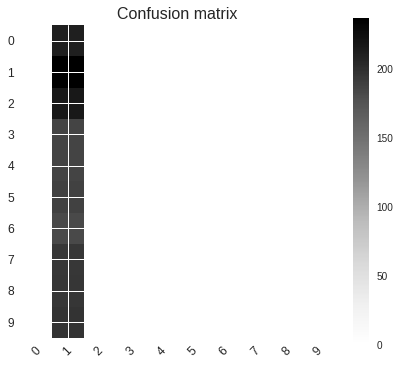

Test accuracy: 0.1185
Test accuracy: 0.1185


In [19]:
# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test, y_pred_test_classes))
plt.xticks(np.arange(10), mnist_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), mnist_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))
print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))

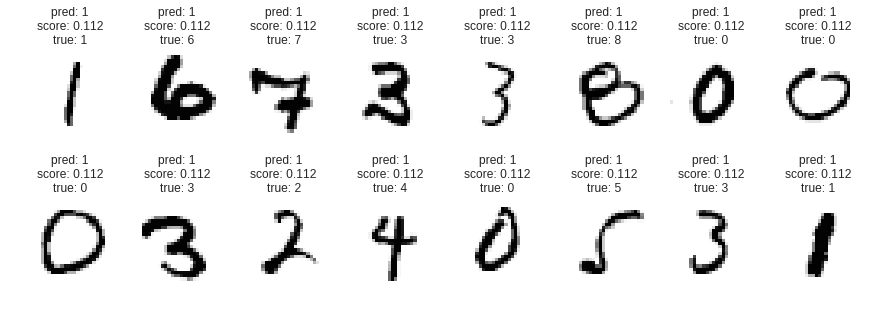

In [20]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index,:])
        pred_label = mnist_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = mnist_classes[y_test[random_index, ]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()